# Practical Session 4
## Biomedical Signals and Images 
### ETRO: Deparment of Electronics and Informatics
### Vrije Universiteit Brussel

Jakub Ceranka, Hamza Mekhzoum, Evgenia Papavasileiou and Jef Vandemeulebroucke



<font color=blue>Students names: </font> <Br>
<font color=blue>Academic Year </font>: 2022-2023

### Purpose
The purpose of this exercise session is to obtain insight into feature extraction techniques applied on medical image processing as well as processing of the extracted features. For more information on these concepts see the
related material on the course slides.

The jupyter notebook should be submitted as the report of each practical session by teams of <b>two</b> students. In colab you should download the notebook in the format *.ipynb and save it as a pdf version through print->save as pdf. Both the jupyter notebook and the pdf should be uploaded on canvas in a zip file before the deadline.The zip file should be named as Surname1Name1_Surname2Name2.zip. The <b>deadline</b> for the report submission is <b>January 2th 2022, at 23.59</b>. Any report sent after the deadline will not be graded.


### Required libraries
During this practical session, the following libraries will be used:

* Numpy 
* Simple ITK 
* Matplotlib
* Sklearn
* pandas

To import any external library, you need to import it using the **import** statement followed by the name of the library.

## Part 1: Feature Extraction
In the first part of this practical session you are given a CT image of a lung, together with the segmentation mask and you are asked to extract features belonging to two important groups of features; first order statistics and shape features.

###  Load the image
1. Download the DICOM image.
2. Use SimpleITK functions SimpleITK.ImageSeriesReader() with GetGDCMSeriesFileNames() to read the DICOM series by providing the whole path where the Dicom series is stored. Documentation can be found [here:](https://simpleitk.readthedocs.io/en/master/link_DicomSeriesReader_docs.html) <br>
3. Use function SimpleITK.ReadImage() to obtain the itk images by providing the obtained dicom series. 
4. Use function SimpleITK.GetArrayFromImage() to convert the itk image of the previous step into a numpy array.

*To see the documentation of a function you can type help(the name of a function). For example:<br>
help(SimpleITK.GetImageFromArray) returns <br>
GetImageFromArray(arr, isVector=None) <br>
    Get a SimpleITK Image from a numpy array. If isVector is True, then the Image will have a Vector pixel type, and the last dimension of the array will be considered the component index. By default when isVector is None, 4D images are automatically considered 3D vector images.*


In [154]:
import SimpleITK as sitk
import sys
import os
import numpy as np


#loading the dicom series
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames("/home/swt/Programme/biomed/biomedSignals/WPO4/LUNG/LUNG")
image = sitk.ReadImage(dicom_names)
imageArray = sitk.GetArrayFromImage(image)

size = image.GetSize()

print("Image as itk: ", size)
print("Image as array: ", imageArray.shape)


Image as itk:  (512, 512, 134)
Image as array:  (134, 512, 512)


### Now load the mask
5. Download the mask.
6. Use SimpleITK function sitk.ReadImage() to read the mask by giving as input the whole path where the mask is stored. 
7. Convert the itk mask to a numpy array with function SimpleITK.GetArrayFromImage(). 

In [155]:
#loading the mask

mask = sitk.ReadImage("/home/swt/Programme/biomed/biomedSignals/WPO4/lung_mask.mhd")
maskArray = sitk.GetArrayFromImage(mask)

print("Dimensions itk image: ", mask.GetSize())
print("Dimension np array: ", maskArray.shape)



Dimensions itk image:  (512, 512, 134)
Dimension np array:  (134, 512, 512)


Note: You can find some examples of SimpleITK's functions [here.](http://simpleitk.github.io/SimpleITK-Notebooks/01_Image_Basics.html)
On that page it is mentioned that:
"The order of index and dimensions need careful attention during conversion.
ITK's Image class does not have a bracket operator. It has a GetPixel which takes an ITK Index object as an argument, which is an array ordered as (x,y,z). This is the convention that SimpleITK's Image class uses for the GetPixel method as well.
While in numpy, an array is indexed in the opposite order (z,y,x)."

To observe this, get the size of the itkimage resulting from function SimpleITK.ReadImage in step 3. To do this use function GetSize() <br>
Now get the size of the numpy image resulting from function SimpleITK.GetArrayFromImage in step 4.

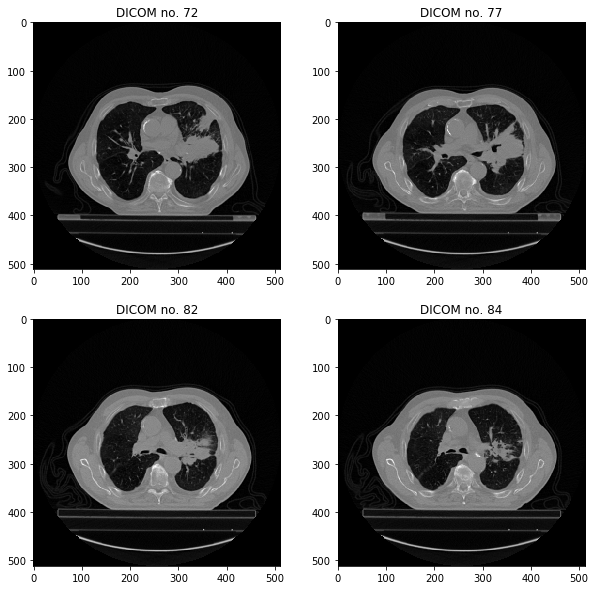

In [156]:
from pylab import show,title,figure,imshow,subplot,subplots_adjust, hist

#Plotting dicom images
h,w=2,2    # figure height and width 
figure(figsize=(10,10))
subplots_adjust(hspace=.2)

subplot(h,w,1)
imshow(imageArray[71], cmap="gray")
title('DICOM no. 72')

subplot(h,w,2)
imshow(imageArray[76], cmap="gray")
title('DICOM no. 77')

subplot(h,w,3)
imshow(imageArray[81], cmap="gray")
title('DICOM no. 82')

subplot(h,w,4)
imshow(imageArray[83], cmap="gray")
title('DICOM no. 84')
show()

### Visualize some slices of the CT image
In a 2X2 matplolib subplot visualize slices **72,77,82,84** <br>
Use function imshow and a gray colormap 

*Remember python's indexes start from zero*

### Overlay with the masks
Overlay the above slices with the masks.
When plotting the masks, define a value for the parameter 'alpha' of function imshow() and use a different colormap.

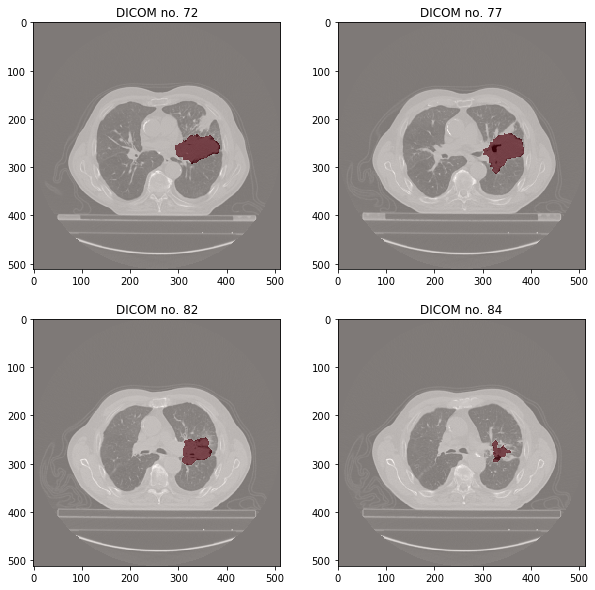

In [157]:
#Plotting overlayed images

#extracting dicom no. 72, 77, 82, 84
images = [imageArray[71], imageArray[76], imageArray[81], imageArray[83]]
masks = [maskArray[71], maskArray[76], maskArray[81], maskArray[83]]

h,w=2,2    # figure height and width 
figure(figsize=(10,10))
subplots_adjust(hspace=.2)

subplot(h,w,1)
imshow(images[0], cmap="gray")
imshow(masks[0], cmap="Reds", alpha=0.5)
title('DICOM no. 72')

subplot(h,w,2)
imshow(images[1], cmap="gray")
imshow(masks[1], cmap="Reds", alpha=0.5)
title('DICOM no. 77')

subplot(h,w,3)
imshow(images[2], cmap="gray")
imshow(masks[2], cmap="Reds", alpha=0.5)
title('DICOM no. 82')

subplot(h,w,4)
imshow(images[3], cmap="gray")
imshow(masks[3], cmap="Reds", alpha=0.5)
title('DICOM no. 84')
show()

### Feature Extraction: First Order Statistics <br>
To begin with you are going to extract first order statistics, i.e. features that describe the distribution of voxel intensities within the image region of interest (ROI). <Br>
To obtain the ROI, take only the part of the image *where the mask has true labels, i.e. when mask==1*. Use function numpy.where() to get the coordinates and apply them to the numpy image. <br>
Convert the obtained image to type ['float'](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html).
This is necessary for the calculations that follow.


In [158]:
#Extract region of interest
#rois = []
#for i in range(len(images)):
#    rois.append(np.where(masks[i], images[i], 0).astype("float"))
roi = np.where(maskArray, imageArray, 0).astype("float")

Let $X$ be the set of $N_p$ voxels included in the ROI. Given the definitions of the features, calculate the values of the features in the ROI you obtained in the previous step.<br>
Note: you can use existing numpy functions to calculate some features. For example, numpy.mean to calculate feature 'average gray level intesity'. 

#### 1. Minimum
The minimum gray level intensity within the ROI.

In [159]:
#mins = [np.min(img) for img in rois]
#print("Minima: ", mins)
minimum = np.min(roi)
print("Minimum: ", minimum)

Minimum:  -1021.0


#### 2. Maximum
The maximum gray level intesity within the ROI. <br>


In [160]:
#maxs = [np.max(img) for img in rois]
#print("Maxima: ", maxs)
maximum = np.max(roi)
print("Maximum: ", maximum)

Maximum:  1040.0


#### 3. Range
The range of gray values in the ROI.<br>
$Range=max(X(i))-min(X(i))$

In [161]:
#ranges = []
#for i in range(len(images)):
#    ranges.append(maxs[i]-mins[i])
#print("Ranges: ", ranges)
r = maximum-minimum
print("Range: ", r)

Range:  2061.0


#### 4. Average
The average gray level intesity within the ROI. <br>
$Mean=\frac{1}{N_p}\sum^{N_p}_{i=1}X(i)$

In [162]:
#means = [np.mean(img) for img in rois]
#for i in range(len(means)):
#    print('Mean {0:d}: {1:.3f}'.format(i+1, means[i]))
non_zeros = roi[roi!=0]
mean = np.sum(roi) / len(non_zeros)
print("Mean: ", mean)

Mean:  -63.33528084901823


#### 5. Energy
Energy is a measure of the magnitude of voxel values in an image. <br>

$Energy=\sum^{N}_{i=1}(X(i)+c)^2$

$c$ is a parameter which is used to shift the intensities to prevent negative values in X.<br>

When using CT images a good practice is to use the value $1024$. Can you explain why? <br>
<font color=blue> As air has a value of around -1000 units on the hounsfield scale, values below -1024 are unexpected. Therefore, adding 1024 is expected to achieve just positive values.</font>

In [163]:
#energies = [np.sum((img+1024)**2) for img in rois]
#print("Energies: ", energies)
non_zeros = roi[roi!=0]
energy = np.sum((non_zeros+1024)**2)
print("Energy: ", energy)


Energy:  52129077660.0


#### 6. Root Mean Square
The squared root of the mean of the squared intensities in the ROI.<br>
$RMS=\sqrt{\frac{1}{N_p}\sum^{N_p}_{i=1}(X(i)+c)^2}$

In [164]:
import math
#rms = [math.sqrt(np.sum((img+1024)**2)/(len(img)**2)) for img in rois]
#print("Root Mean Squares: ", rms)
rms = math.sqrt(energy/len(non_zeros))
print("Roomt mean square: ", rms)

Roomt mean square:  981.7424917374368


#### 7. Standard Deviation

In [165]:
#standardDevs = [np.std(img) for img in rois]
#print("Standard deviations: ", standardDevs)
stdDev = non_zeros.std()
print("Standard deviation: ", stdDev)

Standard deviation:  202.3403505517285


### Feature Extraction: Shape Features

In this exercise you are going to extract some shape features which are descriptors of the three-dimensional size and shape of the ROI and they are independent from the gray level intensity distribution in the ROI. Calculate the following features

#### 1. Volume
$Volume\approx N_p * V_i$ <br>
You can approximate volume by multiplying the total number of pixels with the volume of each pixel. To do this you need to get the size of a pixel by using the function GetSpacing(). The spacing is the geometric distance between image samples along each dimension.<br>

In [166]:
voxelSize = image.GetSpacing()
voxVolume = voxelSize[0]*voxelSize[1]*voxelSize[2]
print("The volume of a voxel is: %.2f mm³" % voxVolume)
totalVolume = voxVolume * len(non_zeros) / (10**6)
print('Volume of the ROI in liters: {0:.3f} l'.format(totalVolume))

The volume of a voxel is: 2.86 mm³
Volume of the ROI in liters: 0.155 l


#### 3. Surface Area to Volume ratio
Given that the surface area is 23501.6761259, calculate the surface area to volume ratio. <br>
This feature gives an insight of the shape of the ROI. A lower value indicates a more compact (sphere-like) shape. 

In [167]:
ratio = 23501.6761259 / (voxVolume * len(non_zeros))
print('The surface area to volume ratio is: {0:.3f}'.format(ratio))

The surface area to volume ratio is: 0.152


#### 4. Compactness 
 a measure of how compact the shape of the tumor is relative to a sphere (most compact). It is therefore correlated to Sphericity and redundant. It is provided here for completeness. The value range is [0,1/(6pi)], where a value of 16π indicates a perfect sphere.<br>
$Compactness=\frac{Volume}{\sqrt{\pi \cdot Surface^3}}$

In [168]:
compactness = (totalVolume*10**6)/math.sqrt(math.pi * 23501.6761259**3)
print("Range: [ 0, ", 1/(6*math.pi), "]")
print('The compactness is: {0:.10f}'.format(compactness))

Range: [ 0,  0.05305164769729845 ]
The compactness is: 0.0242316514


#### 5. Shperical Disproportion
Spherical Disproportion is the ratio of the surface area of the tumor region to the surface area of a sphere with the same volume as the tumor region, and by definition, the inverse of Sphericity. Therefore, the value range is greater than 1 with a value of 1 indicating a perfect sphere. <br>
$Spherical Disporportion=\frac{Surface}{4\cdot\pi\cdot R^2}$
where $R$ the radius of a sphere with volume equal to the volume of the tumor, i.e. $R=\sqrt[3]{\frac{3\cdot Volume}{4 \cdot \pi}}$

In [169]:
radius = (3 * totalVolume * 10**6 / (4*math.pi))**(1/3)
print('The radius is {0:.3f} mm'.format(radius))
sphDis = 23501.6761259 / (4*math.pi*radius**2)
print('The spherical disproportion is: {0:.3f}'.format(sphDis))

The radius is 33.305 mm
The spherical disproportion is: 1.686


## Part 2: Feature Visualization
In this exercise you are given the values of the above features extracted from the CT images of 122 patients. Download the file features.csv that contains all the features extracted from these patients. 
- Load the features in pandas dataframe using function [pd.read_csv()]( https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Define ';' as the delimeter. 
- Print the first 10 rows of the dataframe using function [head()]( https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)
- Drop the last column of the frame using function [drop]( https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) The last column of this dataframe contains the labels assigned to each lesion found in the CT scan, i.e. benign (no cancer) or malignant. 


In [170]:
import pandas as pd
data = pd.read_csv("/home/swt/Programme/biomed/biomedSignals/WPO4/features.csv", delimiter=";")
data.head()
dataNoLabel = data.drop(["label"], axis=1)

Normalize your features in the range $[0,1]$. A normalized feature is obtained like this <br>$Normalized \, Feature=\frac{original \, Feature-min(Feature)}{max(Feature)-min(Feature))}$ <br>
However, using scikit-learn you can do that with  [this function]( https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [171]:
from sklearn.preprocessing import MinMaxScaler
print(type(data))
scaler = MinMaxScaler()
dataScaled = pd.DataFrame(scaler.fit_transform(dataNoLabel), columns=dataNoLabel.columns)
dataScaled.head()

<class 'pandas.core.frame.DataFrame'>


,min,max,range,average,energy,rms,std,volume,surfacde,surfaceovervolume,sphercal disporportion,compactness
0,0.000000,0.182423,0.248682,0.807346,1.000000,0.302702,0.620971,0.542413,0.733007,0.043238,0.135673,0.689769
1,0.150000,0.054261,0.109767,0.732371,0.119012,0.349388,0.666168,0.051161,0.180696,0.319760,0.339772,0.399630
2,0.071429,0.179760,0.236899,0.809627,0.118403,0.189809,0.390332,0.126290,0.386554,0.252952,0.489989,0.260591
3,0.000000,0.850200,0.870698,0.882106,0.139664,0.215762,0.464299,0.124793,0.398841,0.268978,0.537482,0.225040
4,0.138095,0.140146,0.191318,0.782692,0.113629,0.306402,0.614799,0.060205,0.155949,0.207366,0.109212,0.740556


Get two sets of datasets; one where the label is benign (benignData) and one where the label is malignant (MalignantData)

In [172]:
dataBenign = data[data["label"] == 0]
dataBenign.head()

,min,max,range,average,energy,rms,std,volume,surfacde,surfaceovervolume,sphercal disporportion,compactness,label
0,-1024,615,1639,-49.124253,7183072911,239.522345,234.430718,358532.54670,35689.207210,0.099542,1.462291,0.030002,0
1,-961,230,1191,-100.581455,868119204,267.731628,248.120124,34680.90216,9287.689178,0.267804,1.805912,0.021860,0
2,-994,607,1601,-47.559032,863753559,171.308006,164.573908,84208.48846,19128.126360,0.227152,2.058817,0.017959,0
3,-1024,2621,3645,2.184743,1016158941,186.989867,186.977103,83221.56539,19715.454000,0.236903,2.138777,0.016961,0
4,-966,488,1454,-66.045163,829535347,241.757717,232.561455,40642.89029,8104.716252,0.199413,1.417742,0.031427,0


In [173]:
dataMalign = data[data["label"] == 1]
dataMalign.head()

,min,max,range,average,energy,rms,std,volume,surfacde,surfaceovervolume,sphercal disporportion,compactness,label
11,-869,261,1130,-102.634370,581820887,273.978060,254.027879,22195.66284,5116.629486,0.230524,1.339639,0.034215,1
12,-1010,1118,2128,-28.229098,3237552106,297.081741,295.737517,105044.96190,18969.007720,0.180580,1.761883,0.022685,1
14,-719,625,1344,1.371912,88216518,111.584797,111.576363,20288.51390,7741.790612,0.381585,2.152074,0.016804,1
16,-967,221,1188,-122.931395,1215902059,264.096857,233.741357,49920.91217,13369.852900,0.267821,2.039173,0.018219,1
17,-982,1095,2077,39.250522,1154882274,255.356735,252.322132,50671.57745,12640.286410,0.249455,1.908812,0.020117,1


Print the mean and standard deviation of all the features of the benign and malignant datasets separately

In [174]:
meanBenign = dataBenign.mean(axis=0)
meanBenign

min                      -9.473906e+02
max                       6.439688e+02
range                     1.591359e+03
average                  -6.799685e+01
energy                    1.405329e+09
rms                       2.166943e+02
std                       1.887832e+02
volume                    1.143182e+05
surfacde                  1.744509e+04
surfaceovervolume         2.194088e-01
sphercal disporportion    1.684432e+00
compactness               2.561566e-02
label                     0.000000e+00
dtype: float64

In [175]:
stdBenign = dataBenign.std(axis=0)
stdBenign

min                       9.061984e+01
max                       5.772050e+02
range                     5.932205e+02
average                   1.190065e+02
energy                    1.571181e+09
rms                       1.091173e+02
std                       6.740980e+01
volume                    1.244751e+05
surfacde                  1.266060e+04
surfaceovervolume         8.914609e-02
sphercal disporportion    3.173084e-01
compactness               6.075560e-03
label                     0.000000e+00
dtype: float64

In [176]:
meanMalign = dataMalign.mean(axis=0)
meanMalign

min                      -9.273276e+02
max                       3.230172e+02
range                     1.250345e+03
average                  -1.350414e+02
energy                    5.103993e+08
rms                       2.573551e+02
std                       2.056736e+02
volume                    4.134792e+04
surfacde                  8.408598e+03
surfaceovervolume         3.331178e-01
sphercal disporportion    1.605766e+00
compactness               2.752767e-02
label                     1.000000e+00
dtype: float64

In [177]:
stdMalign = dataMalign.std(axis=0)
stdMalign

min                       7.778499e+01
max                       3.051416e+02
range                     3.342762e+02
average                   1.226990e+02
energy                    6.158978e+08
rms                       1.168285e+02
std                       6.623891e+01
volume                    5.571330e+04
surfacde                  8.726684e+03
surfaceovervolume         1.414928e-01
sphercal disporportion    2.999285e-01
compactness               6.527418e-03
label                     0.000000e+00
dtype: float64

Use matplotlib's [violin plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.violinplot.html) to plot the distribution of the first feature in the benign and the malignant dataset. 
You can find an example [here](https://www.tutorialspoint.com/matplotlib/matplotlib_violin_plot.htm)

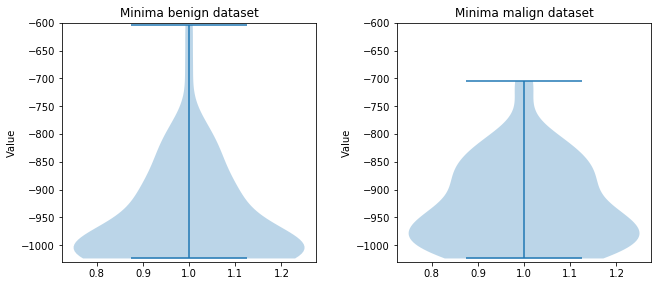

In [202]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.tight_layout(pad = 5)
ax1.violinplot(dataBenign['min'])
ax1.set_title("Minima benign dataset")
ax1.set_ylim((-1030, -600))
ax1.set_ylabel("Value")
ax2.violinplot(dataMalign['min'])
ax2.set_title("Minima malign dataset")
ax2.set_ylim((-1030, -600))
ax2.set_ylabel("Value")
plt.show()

Plot the boxplots of the benign ad malignant datasets in two separate graphs. A boxplot shows the distribution of a feature using its quartiles. To do this you can use function pyplot.boxplot(). 

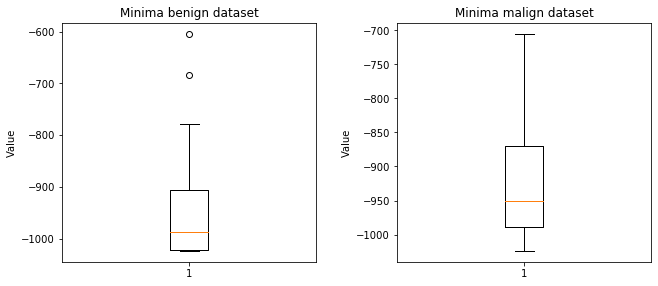

In [207]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )
fig.tight_layout(pad=5)
ax1.boxplot(dataBenign["min"])
ax1.set_title("Minima benign dataset")
ax1.set_ylabel("Value")
ax2.boxplot(dataMalign["min"])
ax2.set_title("Minima malign dataset")
ax2.set_ylabel("Value")
plt.show()

Plot the histogram of the feature surface over volume of the benign and malignant datasets in one graph. The histogram shows the distribution of a single feature. To do this you can use function pyplot.hist.  

Finally, plot in a 2X2 figure the scatter plots of the following combinations of features:
- min and rms
- max and range
- range and surface over volume
- volume and surface

A scatterplot shows the relation between two features.

Describe the relationships you see between the features

<font color=blue> Your answer here: </font>

## Part 3: A simple classifier

Take the features resulting from dropping the last column of the dataframe in the beginning of part 2. This is the set of features describing the ROIs of the 122 patients. The dropped column is the label assigned to the ROI.<br>
In this exercise you will train a classifier with a portion of the features' set and use it to predict the label of an unseen set of features
1. Divide your dataset in training and testing parts so that 70% of the dataset is a training set and 30% a test set. (use random state=40). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
2. Normalize the training set and apply the normalization on the test set. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
3. Use the normalized training set to train an SVM classifier and predict on the unseen testing set. Use the default values of the classifier found [here]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
4. Calculate the score of your classifier using [this function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.score)